### Strategy Backtester 2.0

#### Tickers

In [1]:
import pandas as pd

In [2]:
# getting the s&p500 tickers
symbols_sp = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
symbols_sp = symbols_sp.Symbol.to_list()

# getting the IDX Tickers | select high market cap stocks
symbols_idx = ['BBRI.JK', 'BBNI.JK', 'BMRI.JK', 'BBCA.JK', 'UNVR.JK', 'TLKM.JK', 'BRMS.JK', 'BUKA.JK', 'ARTO.JK', 
           'ASII.JK','ICBP.JK', 'TPIA.JK', 'BYAN.JK', 'GOTO.JK']

#### Array of Dataframes

In [3]:
import yfinance as yf

In [4]:
# downloading each dataframe
dfs = {}
for symbol in symbols_sp:
    # yf can't find stock tickers like BRK.B | only use on s&p500 testing
    symbol = symbol.replace(".","-") 
    # past 6 years of data
    dfd = yf.download(symbol, start='2016-01-01', end='2022-12-31', progress=False) 
    # array of dataframes
    dfs[symbol] = pd.DataFrame(dfd) 

#### Refiltering
Some dataframes have less than 14 rows for some reason, and running this cell means I don't have download all 500 something dataframes over again.

In [14]:
dfr ={}
for symbol in symbols_sp:
    # yf can't find stock tickers like BRK.B | only use on s&p500 testing
    symbol = symbol.replace(".","-") 
    temp = dfs[symbol]
    temp = temp.drop(temp.columns[6:], axis=1)
    if len(temp) >= 14:
        dfr[symbol]=pd.DataFrame(temp)
    elif len(temp) < 14:
        symbols_sp.remove(symbol)

#### Applying Indicators

In [6]:
import ta

In [7]:
def applyindicators(df):
    #necessary indicators for RSI x BB with ATR Bands strategy
    # 30-period BB's with 2 multiplier
    df['SMA_30'] = df.Close.rolling(window=30).mean()
    df['stddev'] = df.Close.rolling(30).std() #30 day standard deviation
    df["upper"] = df.SMA_30 + 2 * df.stddev #upper bolinger band
    df["lower"] = df.SMA_30 - 2 * df.stddev #lower bolinger band
    # 13-period RSI 
    df["rsi"] = ta.momentum.rsi(df.Close, 13)
    # 14-period ATR, 2 as upper mult and 3 as lower mult
    df['atr'] = ta.volatility.AverageTrueRange(df.High, df.Low, df.Close, window=14).average_true_range()
    df['atrUpper'] = df.Open + (df['atr']*2)
    df['atrLower'] = df.Open - (df['atr']*3)
    
    
    # necessary indicators for MACD x RSI x Stochastic strategy
    # 12, 26 MACD with 10 signal
    df["macd"] = ta.trend.macd(df["Close"], window_fast=12, window_slow=26)
    df["signal"] = ta.trend.macd_signal(df["Close"], window_fast=12, window_slow=26, window_sign=10)
    # 14-period Stochastic with 3-period smoothing
    df["stoch"] = ta.momentum.stoch(df["High"], df["Low"], df["Close"], window=14)
    df["stoch"] = df["stoch"].rolling(window=3).mean()
    # 14-period RSI
    df["rsi14"] = ta.momentum.rsi(df.Close, 14)
    # 14-period rsi moving average & volume's 30-period moving average
    df['rsi14sma'] = df.rsi14.rolling(window=14).mean()
    df['vol30sma'] = df.Volume.rolling(window=30).mean()
    # minimum stochastic and low in the past 10 candles
    df['minstoch'] = df['stoch'].rolling(window=10).min()
    df['minlow'] = df['Low'].rolling(window=10).min()
    
    
    # necessary indicators for Serious Backtester's MACD x Stochastic under 200 EMA
    # 70-period Stochastic with 10-period smoothing
    df["stoch"] = ta.momentum.stoch(df["High"], df["Low"], df["Close"], window=70)
    df["stoch"] = df["stoch"].rolling(window=10).mean()
    # 12, 26 MACD with 10 signal
    df["macd"] = ta.trend.macd(df["Close"], window_fast=12, window_slow=26)
    df["signal"] = ta.trend.macd_signal(df["Close"], window_fast=12, window_slow=26, window_sign=10)
    # 200-period EMA
    df['ema200'] = df.Close.ewm(span=200).mean()

#### Buy Conditions

In [8]:
import numpy as np

In [9]:
# RSI x BB Buy Conditions
def BuyConditions1(df):
    conditions = ((df.Close > df.High.shift(1)) &
                        (df.Close > df.Open) &
                        (df.Close.shift(1) < df.Open.shift(1)) &
                         (df.Low.shift(1) < df.lower) &
                         (df.rsi.shift(1) < 30))
    df["Buy"] = np.where(conditions, 1, 0)
    df["Buyprice"] = np.where((df.Buy == 1), df.Open, 0)

    
# MACD x RSI x Stochastic
def BuyConditions2(df):
    df['Buy'] = np.where(((df.macd < 0) & (df.signal < 0) & (df.macd.shift() < df.signal.shift()) & (df.macd>df.signal)) &
                         (df.stoch.between(20, 80)) & 
                         ((df['minstoch'])<30) & 
                        (df.rsi14 > df.rsi14sma) & (df.Volume > df.vol30sma), 1, 0)
    df["Buyprice"] = np.where((df.Buy == 1), df.Open, 0)

    
# Serious Backtester's MACD x Stochastic under EMA 200
def BuyConditions3(df):
    df['Buy'] = np.where(((df.macd < 0) & (df.signal < 0) & (df.macd.shift() < df.signal.shift()) & (df.macd>df.signal)) &
                         (df.stoch < 35) & (df.Close < df.ema200), 1, 0)
    df["Buyprice"] = np.where((df.Buy == 1), df.Open, 0)

#### Sell Indicators

In [10]:
# RSI x BB with ATR Bands
def SellIndicators1(df):
    df['BuyUpperATR'] = df['atrUpper'].where(df.Buy == 1)
    df['BuyUpperATR'].ffill(inplace=True)
    df['BuyLowerATR'] = df['atrLower'].where(df.Buy == 1)
    df['BuyLowerATR'].ffill(inplace=True)
    
    
# MACD x RSI x Stochastic
def SellIndicators2(df):
    df['UpSell'] = df.Close + abs(df.Close - (df['minlow']))*1.5
    df['BuyUp'] = df['UpSell'].where(df.Buy == 1)
    df['BuyUp'].ffill(inplace=True)
    df['BuyLow'] = df['minlow'].where(df.Buy == 1)
    df['BuyLow'].ffill(inplace=True)
    
    
# Serious Backtester's MACD x Stochastic under EMA 200
def SellIndicators3(df):
    df['StopLoss'] = df.Buyprice - (df.Buyprice*0.4)
    df['BuyLow'] = df['StopLoss'].where(df.Buy == 1)
    df['BuyLow'].ffill(inplace=True)

#### Sell Conditions

In [11]:
# RSI x BB Sell Conditions with ATR Bands
def SellConditions1(df):
    conditions = (((df['BuyUpperATR'] < df.Close) | (df['BuyUpperATR'] < df.High) |
                  (df.Close < df.BuyLowerATR) | (df['BuyUpperATR'] < df.Low)))
    df['Sell'] = np.where(conditions,1, 0)
    df['Sellprice'] = np.where((df.Sell == 1), df.Close, 0)

    
# MACD x RSI x Stochastic
def SellConditions2(df):
    df['Sell'] = np.where(((df['BuyLow'] > df.Close) | (df.Close > df.BuyUp) |
                          (df.High > df.BuyUp) | (df.Low < df.BuyLow)),1, 0)
    df['Sellprice'] = np.where((df.Sell == 1), df.Close, 0) 

    
# Serious Backtester's MACD x Stochastic under EMA 200
def SellConditions3(df):
    df["Sell"] = np.where(((((df.macd > 0) & (df.signal > 0) & (df.macd < df.signal) & (df.macd.shift() > df.signal.shift())) &
                         (df.stoch > 65)) |(df.BuyLow > df.Low)) , 1, 0) 
    df['Sellprice'] = np.where((df.Sell == 1), df.Close, 0)

#### Keep Trades

In [12]:
def matchtrades(df): # double filter
    df["keep"] = np.where(((df.Sell == 1) & (df.Buy == 1)) | 
                         ((df.Buy - df.Buy.shift() == 1)) |
                         ((df.Sell - df.Sell.shift() == 1)), 1, 0)

    df = df[df.keep == 1]
    df["keep"] = np.where(( ((df.Sell == 1) & (df.Buy == 1)) | 
                         ((df.Buy == 1) & (df.Sell.shift(-1) == 1) & (df.Buy.shift(-1) == 0)) |
                         ((df.Sell - df.Sell.shift() == 1)) ), 1, 0)
    df = df[df.keep == 1]
    return df

#### Verified Trades Dataframe
if an error arises saying the a symbol isn't in dfr, just rerun the refiltering cell above. The one after downloading the dataframes.

In [17]:
import warnings
warnings.simplefilter('ignore')

In [18]:
trades = {}

for symbol in symbols_sp:
    # yf can't find stock tickers like BRK.B | only use on s&p500 testing
    symbol = symbol.replace(".","-") 
    dfe = dfr[symbol]
    applyindicators(dfe)
    BuyConditions3(dfe)
    SellIndicators3(dfe)
    SellConditions3(dfe)
    trade = matchtrades(dfe)
    if len(trade) > 0:
        trades[symbol] = trade 
        
tradesdf = pd.concat(trades).reset_index()
tradesdf

,level_0,Date,Open,High,Low,Close,Adj Close,Volume,SMA_30,stddev,...,minstoch,minlow,ema200,Buy,Buyprice,StopLoss,BuyLow,Sell,Sellprice,keep
0,MMM,2016-11-04 00:00:00-04:00,167.210007,167.850006,166.419998,166.479996,136.539871,1927500,170.265666,3.705739,...,4.791701,163.850006,171.336600,1,167.210007,100.326004,100.326004,0,0.000000,1
1,MMM,2016-12-29 00:00:00-05:00,178.289993,179.139999,178.029999,178.410004,147.262527,1102000,175.332001,3.023587,...,62.430383,175.050003,172.592958,0,0.000000,0.000000,100.326004,1,178.410004,1
2,MMM,2018-07-09 00:00:00-04:00,198.139999,200.839996,198.070007,200.529999,171.572342,1967100,199.730333,3.771373,...,13.234893,193.509995,213.239744,1,198.139999,118.884000,118.884000,0,0.000000,1
3,MMM,2018-08-10 00:00:00-04:00,203.809998,204.130005,201.000000,201.960007,172.795868,1893200,202.591000,4.289578,...,63.289808,201.000000,211.285672,0,0.000000,0.000000,118.884000,1,201.960007,1
4,MMM,2019-01-07 00:00:00-05:00,191.360001,192.300003,188.660004,190.880005,165.533325,2162200,195.314334,7.477229,...,2.620836,176.869995,204.054335,1,191.360001,114.816000,114.816000,0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,ZTS,2020-05-07 00:00:00-04:00,127.290001,127.500000,123.370003,124.239998,122.047676,3098000,123.906333,5.376828,...,34.075669,122.660004,123.118313,0,0.000000,0.000000,68.177998,1,124.239998,1
6576,ZTS,2022-06-22 00:00:00-04:00,161.179993,166.270004,161.089996,164.210007,163.178238,2137700,164.267333,5.043025,...,8.834398,154.179993,187.021763,1,161.179993,96.707996,96.707996,0,0.000000,1
6577,ZTS,2022-08-04 00:00:00-04:00,181.220001,181.899994,172.820007,174.309998,173.532654,2390900,175.748000,3.759246,...,55.825728,172.820007,184.147886,0,0.000000,0.000000,96.707996,1,174.309998,1
6578,ZTS,2022-11-14 00:00:00-05:00,149.000000,149.550003,146.380005,146.449997,146.106689,2492800,146.649666,6.387078,...,31.531227,124.150002,168.411173,1,149.000000,89.400000,89.400000,0,0.000000,1


#### Duplicate One Day Trades
One Day trades only generate one row, and the system I'm using to analyze the backtest requires a pair of trades.

In [19]:
index = tradesdf[(tradesdf.Buy == 1) & (tradesdf.Sell == 1)].index

# Iterate over the indexes
for i in (index):
    # Get the row to duplicate
    row_to_duplicate = tradesdf.loc[i].to_frame().T
    # Concatenate the new dataframe with the original dataframe
    tradesdf = pd.concat([tradesdf.loc[:i], row_to_duplicate, tradesdf.loc[i+1:]])
tradesdf = tradesdf.reset_index(drop=True)

#### Sort Trades by Buydate

In [20]:
import datetime as dt
from datetime import timedelta

In [21]:
tradesdf['profit'] = 0
for x in range(0, len(tradesdf), 2):
    a = tradesdf.loc[x, 'Buyprice']
    b = tradesdf.loc[x+1, 'Sellprice']
    result = (b-a)/(a+1)
    tradesdf.loc[x:x+1, "profit"] = result

tradesdf = tradesdf.set_index('Date')
profitsdf = pd.DataFrame({"ticker": tradesdf[::2].level_0,
                         "profit": tradesdf[::2].profit,
                         "Buydates": tradesdf[::2].index,
                         "Selldates": tradesdf[1::2].index}).reset_index(drop=True)

profitsdf["time_in_market"] = profitsdf.Selldates - profitsdf.Buydates
sorted_profits = profitsdf.sort_values("Buydates")
sorted_profits = sorted_profits.reset_index(drop=True)

sorted_profits = sorted_profits[sorted_profits['time_in_market'] > timedelta()].reset_index(drop=True)
sorted_profits

,ticker,profit,Buydates,Selldates,time_in_market
0,KMB,0.051975,2016-05-10 00:00:00-04:00,2016-07-12 00:00:00-04:00,63 days
1,GEN,0.236553,2016-05-13 00:00:00-04:00,2016-07-06 00:00:00-04:00,54 days
2,NTAP,0.502917,2016-05-16 00:00:00-04:00,2016-09-06 00:00:00-04:00,113 days
3,GLW,0.054536,2016-05-17 00:00:00-04:00,2016-06-14 00:00:00-04:00,28 days
4,STX,0.584124,2016-05-17 00:00:00-04:00,2016-08-03 00:00:00-04:00,78 days
...,...,...,...,...,...
3285,BDX,0.121622,2022-11-10 00:00:00-05:00,2022-12-19 00:00:00-05:00,39 days
3286,BBWI,0.297459,2022-11-10 00:00:00-05:00,2022-12-13 00:00:00-05:00,33 days
3287,ZTS,-0.001933,2022-11-14 00:00:00-05:00,2022-12-15 00:00:00-05:00,31 days
3288,OGN,0.127065,2022-11-21 00:00:00-05:00,2022-12-28 00:00:00-05:00,37 days


#### Sort Companies by Their Average Profits

In [22]:
ticker_profits = sorted_profits.groupby('ticker').profit.mean().reset_index()
ticker_max = ticker_profits.profit.max()
ticker_min = ticker_profits.profit.min()
ticker_profits.sort_values('profit').T

,203,462,1,191,160,63,427,496,464,348,...,27,84,280,23,211,314,145,168,406,39
ticker,GNRC,USB,AAL,FRT,EPAM,BK,SYY,YUM,VFC,OMC,...,AMAT,CDAY,LRCX,ALGN,HAL,MRO,DVN,ETSY,SEDG,APA
profit,-0.079485,-0.027891,0.008619,0.024506,0.02599,0.027957,0.031141,0.034648,0.034875,0.03988,...,0.292152,0.301717,0.304694,0.308721,0.311276,0.336541,0.355339,0.362798,0.373411,0.453214


#### Dollar Cost Averaging Each Month Dataframe

In [27]:
sorted_profits['year'] = sorted_profits.Selldates.dt.year
sorted_profits['month'] = sorted_profits.Selldates.dt.month
cp = sorted_profits.groupby(['year', 'month']).profit.mean().reset_index()

inve = [60] # DCA Amount
for x in range(len(cp)-1):
    if cp.year[x] == cp.year[x+1] and cp.month[x] < cp.month[x+1]:
        inve.append(((cp.month[x+1]-cp.month[x])*100)+inve[-1])
    elif cp.year[x] != cp.year[x+1]:
        inve.append(cp.month[x+1]*100+((12-cp.month[x])*100)+inve[-1])

cp['invested ($)'] = inve
cp['returns ($)'] = round((cp['invested ($)'] * cp.profit),2)

capcom = [cp['invested ($)'][0] + cp['returns ($)'][0]]
start = 1000
oc = [start + cp['returns ($)'][0]]
for y in range(len(cp)-1):
    temp = capcom[-1]
    capcom.append(round(((cp['invested ($)'][y+1] + (temp - cp['invested ($)'][y]))*cp.profit[y+1] + 
                  cp['invested ($)'][y+1] + (temp - cp['invested ($)'][y])), 3))
    temp2 = oc[-1]
    oc.append(round((temp2 + cp['returns ($)'][y+1]),3))
# Reinvesting profit and DCA'ing
cp['compounded'] = capcom 
# start with $1000 and only reinvest profits
cp['compounding'] = oc
cp

,year,month,profit,invested ($),returns ($),compounded,compounding
0,2016,6,0.061177,60,3.67,63.670,1003.67
1,2016,7,0.066174,160,10.59,174.501,1014.26
2,2016,8,0.139290,260,36.22,312.736,1050.48
3,2016,9,0.113374,360,40.81,459.529,1091.29
4,2016,10,0.046847,460,21.55,585.741,1112.84
...,...,...,...,...,...,...,...
74,2022,8,0.147054,7460,1097.02,2267823.569,33826.20
75,2022,9,0.131284,7560,992.50,2565664.632,34818.70
76,2022,10,-0.174210,7660,-1334.45,2118781.521,33484.25
77,2022,11,0.178008,7760,1381.34,2496060.024,34865.59


#### Final Analysis Helpers

In [28]:
lc=len(cp)-1
lt = len(sorted_profits)

In [29]:
def cagr(initial, end, time):
    return round((((end/initial)**(1/time))-1), 2)

In [30]:
cagr_result = cagr(start, cp.iat[lc,6], 6) * 100

In [31]:
avg_loss = (sorted_profits.loc[(sorted_profits.profit < 0), 'profit']).mean() 
avg_win = (sorted_profits.loc[(sorted_profits.profit > 0), 'profit']).mean()
most = (ticker_profits.loc[(ticker_profits.profit == ticker_max), 'ticker'].values[0])
least = (ticker_profits.loc[(ticker_profits.profit == ticker_min), 'ticker'].values[0])

#### Trade Strategy Analysis

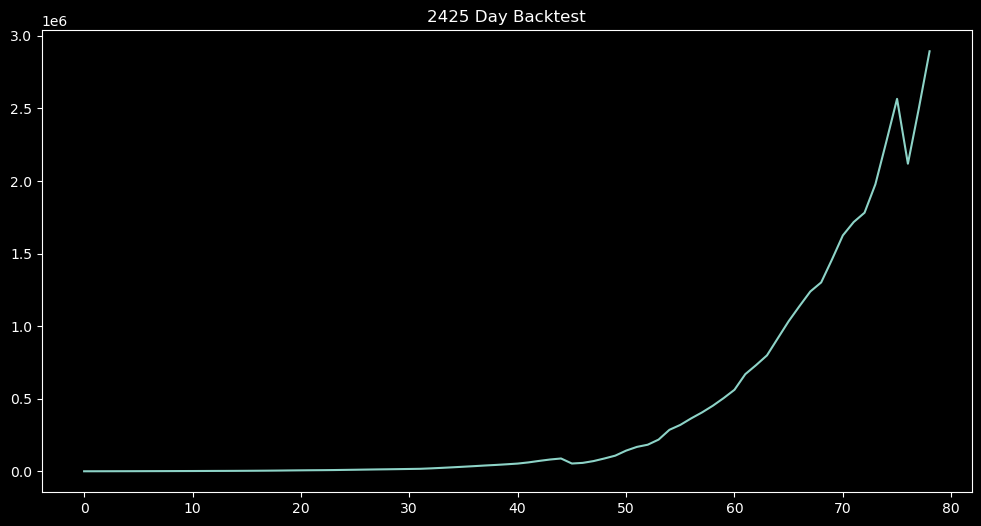

95.8% win rate
13.25% average profit every 55 days when trading
maximum loss of -63.08% a trade, with an average loss of -25.51%
maximum profit of 173.95% a trade, with an average win of 14.96%
there were 3290 trades in 2425 days, which averages to an opportunity every 1 days
Investing a constant amount a month, by the end of this backtest the total growth is 36711%
a one time investment of $1000 would have yielded a 3512% profit, that is 82.0% annually
the most profitable company was APA averaging 45.32% profits
the least profitable company was GNRC averaging -7.95% profits


In [32]:
from matplotlib import pyplot as plt

timeframe = tradesdf.index.max() - tradesdf.index.min()

plt.style.use(["dark_background"])
plt.figure(figsize=(12,6))
(cp.compounded).plot()
plt.title(f"{timeframe.days} Day Backtest")
plt.show()

print(f"{round((len([x for x in sorted_profits.profit if x > 0])/len(sorted_profits)), 3)*100}% win rate")
print(f"{round((sorted_profits.profit.mean() * 100), 2)}% average profit every {sorted_profits.time_in_market.mean().days} days when trading")
print(f"maximum loss of {round((sorted_profits.profit.min() * 100), 2)}% a trade, with an average loss of {round(avg_loss*100, 2)}%")
print(f"maximum profit of {round((sorted_profits.profit.max() * 100), 2)}% a trade, with an average win of {round(avg_win*100, 2)}%")
print(f'there were {lt} trades in {timeframe.days} days, which averages to an opportunity every {round(timeframe.days/(lt))} days')
print(f'Investing a constant amount a month, by the end of this backtest the total growth is {round(((cp.iat[lc, 5]/cp.iat[lc, 3])-1)*100)}%')
print(f'a one time investment of ${start} would have yielded a {round(((cp.iat[lc, 6]/start)-1)*100)}% profit, that is {cagr_result}% annually')
print(f'the most profitable company was {most} averaging {round(ticker_max*100 ,2)}% profits')
print(f'the least profitable company was {least} averaging {round(ticker_min*100 ,2)}% profits')

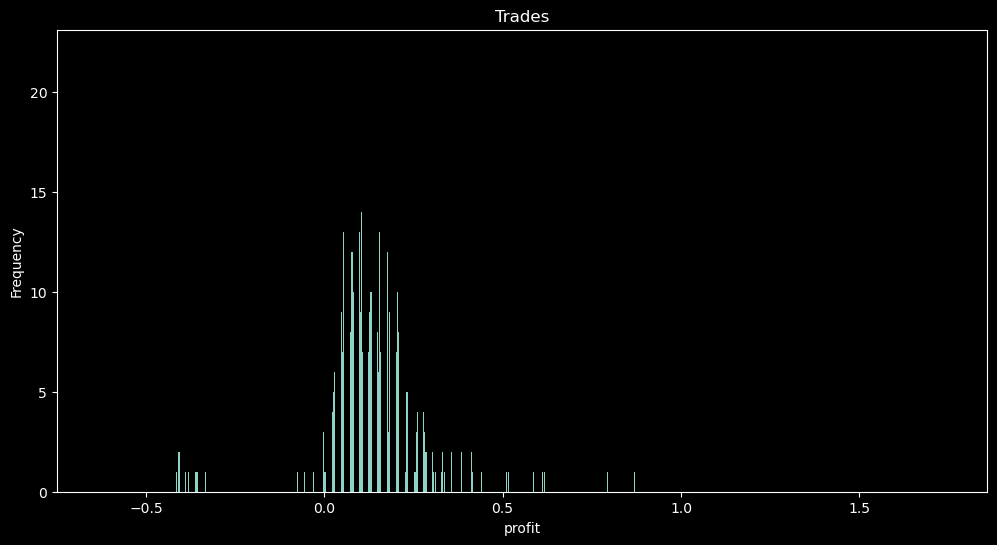

In [33]:
plt.figure(figsize=(12,6))
plt.hist(sorted_profits['profit'], bins=len(sorted_profits), rwidth = 0.4)
plt.xlabel('profit')
plt.ylabel('Frequency')
plt.title('Trades')
plt.show()

High losses are most likely due to stock splits I have not been able to adjust for, maximum losses around 20% are much more probable. That is except for the 3'rd trading strategy where 40% losses are a selling condition.